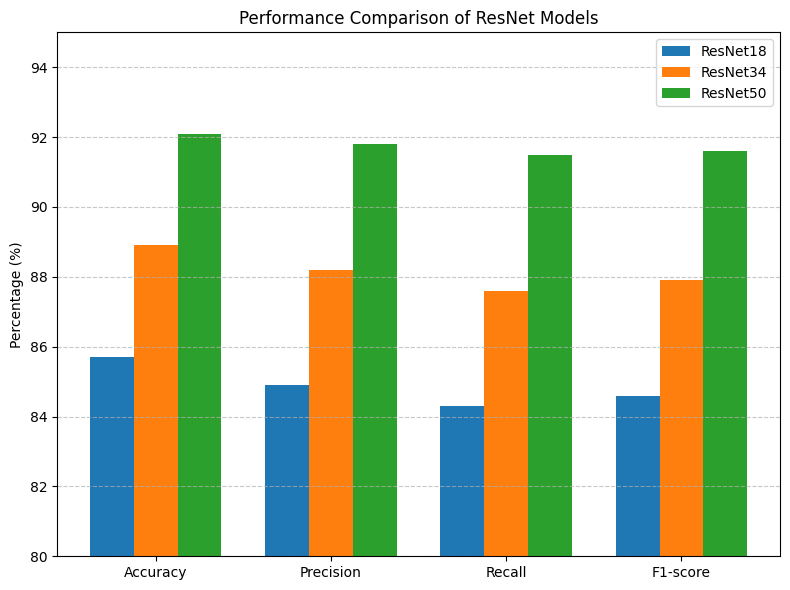

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

resnet18 = [85.7, 84.9, 84.3, 84.6]
resnet34 = [88.9, 88.2, 87.6, 87.9]
resnet50 = [92.1, 91.8, 91.5, 91.6]

x = np.arange(len(metrics))  # label locations
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(8,6))

# Plot bars
ax.bar(x - width, resnet18, width, label='ResNet18')
ax.bar(x, resnet34, width, label='ResNet34')
ax.bar(x + width, resnet50, width, label='ResNet50')

# Labels and title
ax.set_ylabel('Percentage (%)')
ax.set_title('Performance Comparison of ResNet Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Grid and layout
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(80, 95)  # focus on performance range
plt.tight_layout()

# Save and show
plt.savefig("resnet_model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Classes: ['Healthy', 'septoria', 'stripe_rust']

Training: RESNET18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]


Epoch 1/5 - Train Loss: 0.7348, Val Loss: 0.5522, Val MAE: 0.3148
Epoch 2/5 - Train Loss: 0.1880, Val Loss: 0.1953, Val MAE: 0.0394
Epoch 3/5 - Train Loss: 0.0658, Val Loss: 0.0850, Val MAE: 0.0602
Epoch 4/5 - Train Loss: 0.0645, Val Loss: 0.0660, Val MAE: 0.0312
Epoch 5/5 - Train Loss: 0.0448, Val Loss: 0.0975, Val MAE: 0.0810

Training: RESNET34
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 205MB/s]


Epoch 1/5 - Train Loss: 0.6321, Val Loss: 0.4911, Val MAE: 0.3565
Epoch 2/5 - Train Loss: 0.2171, Val Loss: 0.2857, Val MAE: 0.1319
Epoch 3/5 - Train Loss: 0.0989, Val Loss: 0.1540, Val MAE: 0.0394
Epoch 4/5 - Train Loss: 0.0724, Val Loss: 0.1360, Val MAE: 0.0185
Epoch 5/5 - Train Loss: 0.0680, Val Loss: 0.0781, Val MAE: 0.0498

Training: RESNET50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


Epoch 1/5 - Train Loss: 0.7182, Val Loss: 0.4002, Val MAE: 0.1991
Epoch 2/5 - Train Loss: 0.1654, Val Loss: 0.2422, Val MAE: 0.0868
Epoch 3/5 - Train Loss: 0.0846, Val Loss: 0.1204, Val MAE: 0.0475
Epoch 4/5 - Train Loss: 0.0450, Val Loss: 0.0443, Val MAE: 0.0394
Epoch 5/5 - Train Loss: 0.0478, Val Loss: 0.1952, Val MAE: 0.0498


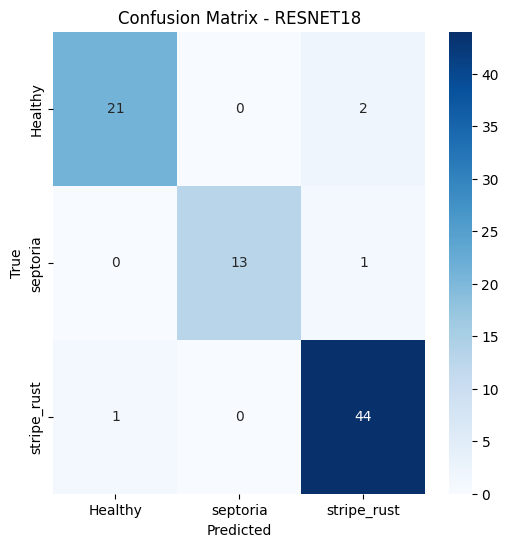


Classification Report - RESNET18

              precision    recall  f1-score   support

     Healthy       0.95      0.91      0.93        23
    septoria       1.00      0.93      0.96        14
 stripe_rust       0.94      0.98      0.96        45

    accuracy                           0.95        82
   macro avg       0.96      0.94      0.95        82
weighted avg       0.95      0.95      0.95        82



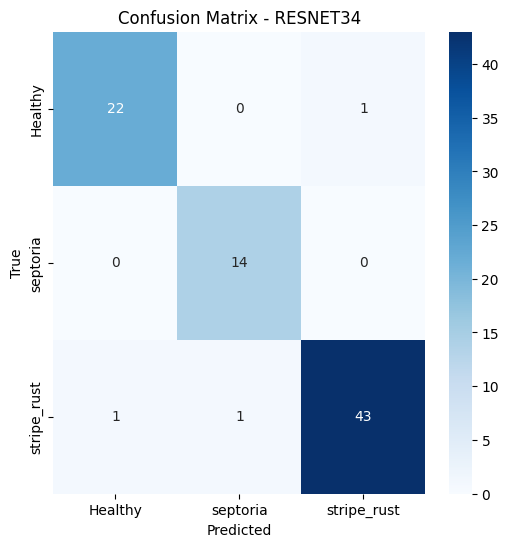


Classification Report - RESNET34

              precision    recall  f1-score   support

     Healthy       0.96      0.96      0.96        23
    septoria       0.93      1.00      0.97        14
 stripe_rust       0.98      0.96      0.97        45

    accuracy                           0.96        82
   macro avg       0.96      0.97      0.96        82
weighted avg       0.96      0.96      0.96        82



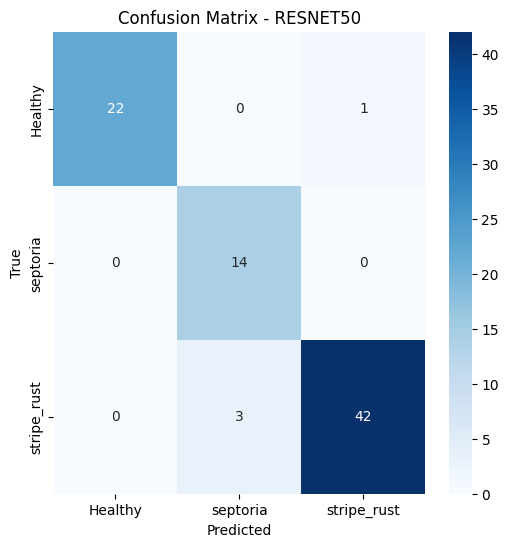


Classification Report - RESNET50

              precision    recall  f1-score   support

     Healthy       1.00      0.96      0.98        23
    septoria       0.82      1.00      0.90        14
 stripe_rust       0.98      0.93      0.95        45

    accuracy                           0.95        82
   macro avg       0.93      0.96      0.95        82
weighted avg       0.96      0.95      0.95        82



In [3]:
# 1. Setup

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2. Dataset and Transforms

data_path = "/content/drive/MyDrive/arch/wheat_leaf (1)"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Train/validation split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)

# 3. Training Function

def train_model(model, criterion, optimizer, num_epochs=5):
    history = {"train_loss": [], "val_loss": [], "val_mae": []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_mae = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)


                val_mae += torch.mean(torch.abs(preds.float() - labels.float())).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae  = val_mae / len(val_loader)

        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_mae"].append(avg_val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

    return model, history


# 4. Build ResNet Models

def build_resnet(model_name, num_classes):
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1")
    elif model_name == "resnet34":
        model = models.resnet34(weights="IMAGENET1K_V1")
    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")


    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

results = {}

for model_name in ["resnet18", "resnet34", "resnet50"]:
    print("\nTraining:", model_name.upper())
    model = build_resnet(model_name, num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model, history = train_model(model, criterion, optimizer, num_epochs=5)
    results[model_name] = {"model": model, "history": history}


# 5. Evaluation & Confusion Matrices

def evaluate_model(model, dataloader, class_names, model_name="Model"):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"\nClassification Report - {model_name}\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Evaluates each model
for model_name in results.keys():
    evaluate_model(results[model_name]["model"], val_loader, class_names, model_name=model_name.upper())


Using device: cuda
Classes: ['Healthy', 'septoria', 'stripe_rust']
Train size: 325 Val size: 82

Training: RESNET18
Epoch 1/5 - Train Loss: 0.6446, Val Loss: 0.5220, Val MAE: 0.3322
Epoch 2/5 - Train Loss: 0.2049, Val Loss: 0.2612, Val MAE: 0.1516
Epoch 3/5 - Train Loss: 0.1133, Val Loss: 0.1040, Val MAE: 0.0312
Epoch 4/5 - Train Loss: 0.0502, Val Loss: 0.0939, Val MAE: 0.0521
Epoch 5/5 - Train Loss: 0.0544, Val Loss: 0.0916, Val MAE: 0.0891

Training: RESNET34
Epoch 1/5 - Train Loss: 0.6192, Val Loss: 0.3290, Val MAE: 0.1678
Epoch 2/5 - Train Loss: 0.2453, Val Loss: 0.1622, Val MAE: 0.0868
Epoch 3/5 - Train Loss: 0.0769, Val Loss: 0.2244, Val MAE: 0.0938
Epoch 4/5 - Train Loss: 0.0413, Val Loss: 0.0992, Val MAE: 0.0914
Epoch 5/5 - Train Loss: 0.0196, Val Loss: 0.0773, Val MAE: 0.0417

Training: RESNET50
Epoch 1/5 - Train Loss: 0.6104, Val Loss: 0.3519, Val MAE: 0.1806
Epoch 2/5 - Train Loss: 0.1621, Val Loss: 0.1385, Val MAE: 0.1076
Epoch 3/5 - Train Loss: 0.0871, Val Loss: 0.1174, Va

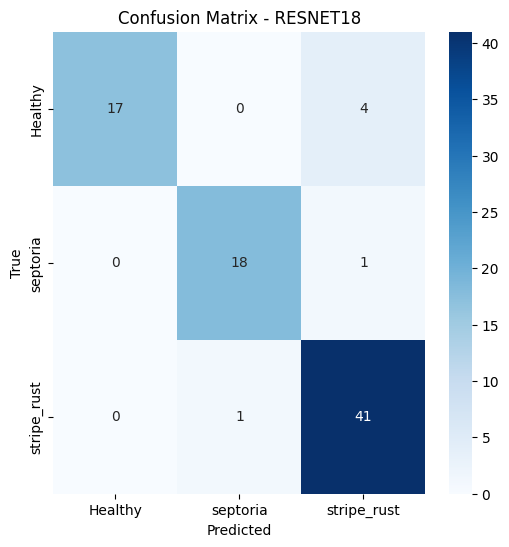


Classification Report - RESNET18

              precision    recall  f1-score   support

     Healthy       1.00      0.81      0.89        21
    septoria       0.95      0.95      0.95        19
 stripe_rust       0.89      0.98      0.93        42

    accuracy                           0.93        82
   macro avg       0.95      0.91      0.92        82
weighted avg       0.93      0.93      0.93        82



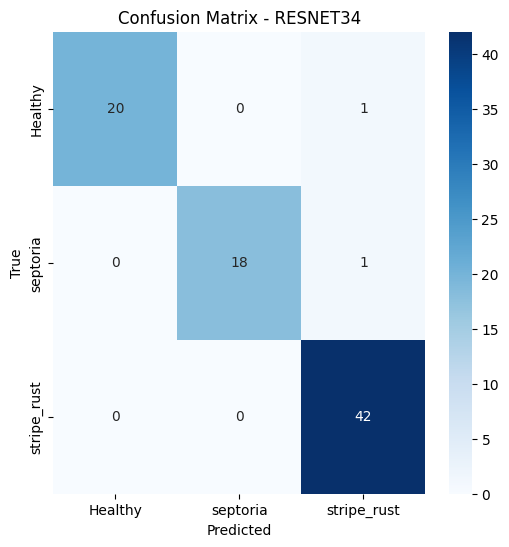


Classification Report - RESNET34

              precision    recall  f1-score   support

     Healthy       1.00      0.95      0.98        21
    septoria       1.00      0.95      0.97        19
 stripe_rust       0.95      1.00      0.98        42

    accuracy                           0.98        82
   macro avg       0.98      0.97      0.98        82
weighted avg       0.98      0.98      0.98        82



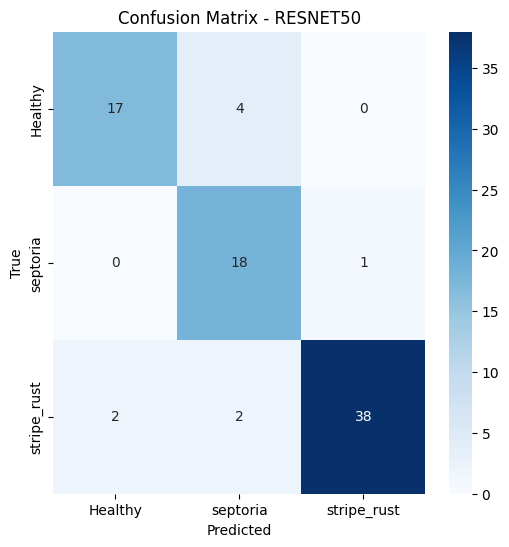


Classification Report - RESNET50

              precision    recall  f1-score   support

     Healthy       0.89      0.81      0.85        21
    septoria       0.75      0.95      0.84        19
 stripe_rust       0.97      0.90      0.94        42

    accuracy                           0.89        82
   macro avg       0.87      0.89      0.88        82
weighted avg       0.90      0.89      0.89        82



In [4]:
# 1. Setup

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# 2. Dataset and Transforms

data_path = "/content/drive/MyDrive/arch/wheat_leaf (1)"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
])

# Load dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = [s[1] for s in full_dataset.samples]

# Stratified split (80% train, 20% val)
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)
print("Train size:", len(train_dataset), "Val size:", len(val_dataset))


# 3. Training Function

def train_model(model, criterion, optimizer, num_epochs=5):
    history = {"train_loss": [], "val_loss": [], "val_mae": []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, val_mae = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)

                val_mae += torch.mean(torch.abs(preds.float() - labels.float())).item()

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae  = val_mae / len(val_loader)

        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_mae"].append(avg_val_mae)

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

    return model, history


# 4. Build ResNet Models

def build_resnet(model_name, num_classes):
    if model_name == "resnet18":
        model = models.resnet18(weights="IMAGENET1K_V1")
    elif model_name == "resnet34":
        model = models.resnet34(weights="IMAGENET1K_V1")
    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")

    # Replace final layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

results = {}

for model_name in ["resnet18", "resnet34", "resnet50"]:
    print("\nTraining:", model_name.upper())
    model = build_resnet(model_name, num_classes=len(class_names))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model, history = train_model(model, criterion, optimizer, num_epochs=5)
    results[model_name] = {"model": model, "history": history}


# 5. Evaluation & Confusion Matrices

def evaluate_model(model, dataloader, class_names, model_name="Model"):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    print(f"\nClassification Report - {model_name}\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Run for all models
for model_name in results.keys():
    evaluate_model(results[model_name]["model"], val_loader, class_names, model_name=model_name.upper())
